# Análise Quantitativa
## Comparação entre Geração Aleatória e Otimizações Convexas

**Resumo:** A teoria de Markowitz é conhecida por seus estudos analíticos sobre retorno e volatilidade de um portfólio, assim originando em várias métricas e indicadores de performance e risco, como downside risk e índice de Sharpe. Atualmente, podemos usufruir de bibliotecas que otimizam tais índices, nos retornando portfólios mais performáticos. Citamos como exemplo a *pyportfolioopt*, que realiza otimizações convexas (da Álgebra Linear) sobre estes indicadores. No entanto, também é possível otimizar o portfólio através da geração aleatória dos pesos dos ativos, onde a cada rodada avaliamos a tripla retorno/volatilidade/índice de Sharpe e armazenamos o resultado. No final, selecionamos a carteira de maior índice ou menor volatilidade, em analogia com as otimizações. Neste trabalho selecionamos um conjunto de ações da B3 e executamos ambos os procedimentos com o intuito de compará-los. Mostra-se que, para este conjunto pelo menos, a geração aleatória supera a otimização convexa.

In [1]:
import pandas as pd
import numpy as np
import pypfopt as pf
import quant_tools as qt                        # módulo de funções quants auxiliares
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import visuals                                  # módulo de visualização pessoal
import joblib as jl
from portfolio_class import Portfolio           # classe auxiliar
import warnings
warnings.filterwarnings("ignore")

Analisaremos e compararemos as otimizações levando em consideração os ativos abaixo.
- Ações:
    1. Banco do Brasil - **BBAS3** (financeiro);
    2. Fleury - **FLRY3** (saúde);
    3. Gafisa - **GFSA3** (imobiliário e construção);
    4. Itaúsa - **ITSA4** (holding);
    5. Petrobras - **PETR4** (petróleo e gás/commodities);
    6. Marcolopo - **POMO4** (industrial);
    7. Portobello - **PTBL3** (industrial);
    8. Construtora Tenda - **TEND3** (imobiliário e construção);
    9. Vale - **VALE3** (mineração/commodities).

Avaliaremos a carteira em dois períodos de tempo: entre 05/05/2017 e 06/05/2019, e 06/05/2019 06/05/2021. Dados históricos serão coletados e várias métricas serão computadas referente a estes períodos (inicialmente, teremos carteiras de pesos iguais). As otimizações serão realizadas e faremos um benchmark com as mais promissoras no segundo período (uma espécie de backtest).

## Carteira Passado

In [2]:
# costumo salvar os dados em disco para evitar ficar carregando-os
# constantemente. Cada Portfolio será salvo, com o método dump da
# biblioteca joblib, após os dados terem sido baixados. Da mesma forma,
# para carregá-los utilizamos o método load. Coloco então o código que
# realiza o download dos dados, o que os salvam em disco e o que os carregam

acoes = [
    'BBAS3', 'FLRY3', 'GFSA3',
    'ITSA4', 'PETR4', 'POMO4',
    'PTBL3', 'TEND3', 'VALE3'
]

start_past_dt = dt(2017, 5, 5)
end_past_dt = dt(2019, 5, 6)

# instanciando o objeto Portoflio e realizando o download dos dados
acoes_past = Portfolio('Iguais_Past', acoes, start_past_dt, end_past_dt)

# armazenando em disco
# jl.dump(acoes_past, 'past/acoes_past_pf.pkl')

# para não realizar o download, comente o código acima e descomente
# os abaixo. Os dados são carregados e o objeto é registrado na classe
# (quando o objeto é instanciado, como acima, o registro é automático)

# acoes_past = jl.load('past/acoes_past_pf.pkl')
# Portfolio.register(acoes_past)

acoes_past.prices.describe()

,BBAS3,FLRY3,GFSA3,ITSA4,PETR4,POMO4,PTBL3,TEND3,VALE3
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,33.822907,23.990793,10.742195,8.263943,19.038659,3.552114,4.477317,11.837236,42.249919
std,7.209751,2.914450,2.612282,1.443933,4.804887,0.422865,0.772292,3.481578,9.835942
min,22.410000,18.060000,4.980000,5.710000,11.170000,2.400000,2.800000,6.440000,24.300000
25%,28.167500,20.945000,9.132500,7.110000,14.920000,3.340000,3.830000,8.460000,32.522500
50%,31.735000,25.035000,10.210000,8.200000,18.620000,3.650000,4.770000,12.200000,43.730000
75%,38.935000,26.410000,11.880000,9.572500,23.845000,3.840000,5.070000,14.155000,49.650000
max,50.200000,29.150000,18.510000,10.960000,28.310000,4.410000,5.870000,18.550000,62.200000


### Retornos Individuais

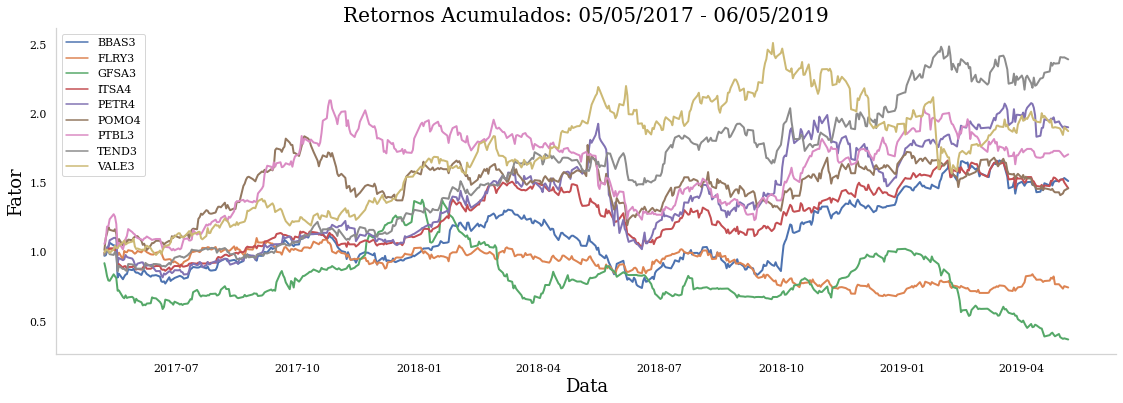

In [3]:
start_past = start_past_dt.strftime('%d/%m/%Y')
end_past = end_past_dt.strftime('%d/%m/%Y')

titles = [
    f'Retornos Acumulados: {start_past} - {end_past}',
    'Data',
    'Fator'
]

# plotly
# qt.plot_lines_go([acoes_past.acm_returns(is_portfolio=False)], titles)

# seaborn
qt.plot_lines_sns(acoes_past.acm_returns(is_portfolio=False), titles, name='returns_past')

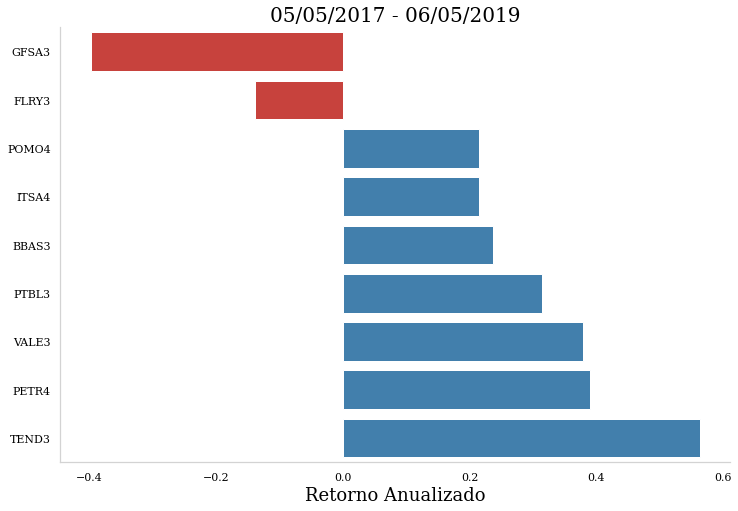

In [4]:
# retornos anualizados
titles = [
    f'{start_past} - {end_past}',
    'Retorno Anualizado',
    None
]

qt.plot_returns_sns(acoes_past.total_returns(), titles)

### Carteira: Retornos e Métricas
#### VaR e CVaR (históricos)

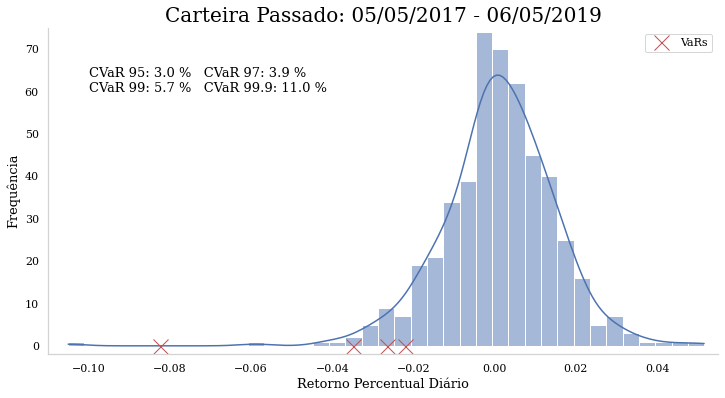

In [8]:
vars_past = acoes_past.var()
c_vars_past = acoes_past.cvar()

# plotly
# hist_data = [
#     acoes_past.d_returns()['Retornos'].fillna(0)
# ]

# group_labels = ['Retorno Percentual Diário']

# fig = ff.create_distplot(hist_data, group_labels, bin_size=.0025)

# fig.add_trace(
#     go.Scatter(
#         x=vars_past.values,
#         y=np.zeros_like(vars_past.values),
#         mode='markers',
#         marker_color='red',
#         marker_symbol='x',
#         name='VaR',
#         text=vars_past.index,
#         hoverinfo='text+x'
#     )
# )


# fig.update_layout(
#     title=f'Carteira Passado: {start_past} - {end_past}',
#     yaxis=dict(
#         title='Frequência',
#         showgrid=False
#     ),
#     xaxis=dict(
#         showgrid=False,
#         showspikes=True,
#         spikethickness=2,
#         spikedash='dot',
#         spikecolor='#999999',
#         spikemode='across'
#     ),
#     plot_bgcolor="#FFF",
#     hoverdistance=100,
#     spikedistance=1000
# )

# fig.add_annotation(
#     x=-.085,
#     y=42,
#     text=f'CVaR 95: {round(c_vars_past.loc[95], 2) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.06,
#     y=42,
#     text=f'CVaR 97: {round(c_vars_past.loc[97], 3) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.085,
#     y=37,
#     text=f'CVaR 99: {round(c_vars_past.loc[99], 3) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.06,
#     y=37,
#     text=f'CVaR 99.9: {round(c_vars_past.loc[99.9], 2) * 100} %',
#     showarrow=False
# )

# fig.show()


# seaborn
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=acoes_past.d_returns()['Retornos'],
    kde=True
)

plt.plot(
    vars_past.values,
    [0, 0, 0, 0],
    'x',
    markersize=15,
    color='r',
    label='VaRs'
)

plt.axis([-.11, .055, -2, 75])
t = (
    f'CVaR 95: {round(c_vars_past.loc[95], 2) * 100} %'
    f'   CVaR 97: {round(c_vars_past.loc[97], 3) * 100} %'
    f'\nCVaR 99: {round(c_vars_past.loc[99], 3) * 100} %'
    f'   CVaR 99.9: {round(c_vars_past.loc[99.9], 2) * 100} %'
)

ax.text(-.1, 60, t, fontdict={'size': 13})

plt.legend()
plt.title(f'Carteira Passado: {start_past} - {end_past}')
plt.xlabel('Retorno Percentual Diário', fontdict={'size': 13})
plt.ylabel('Frequência', fontdict={'size': 13});
plt.savefig('pictures/vars_past.png', dpi=200)
plt.show()

#### Drawdown

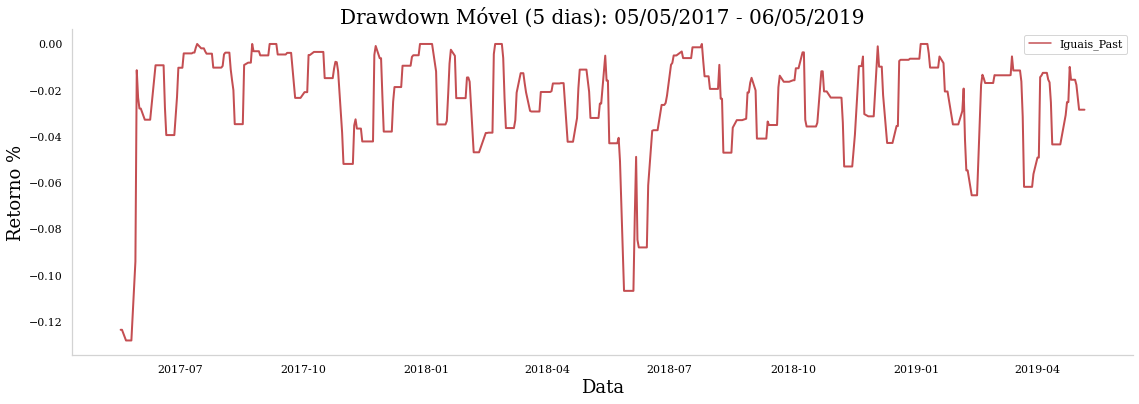

In [12]:
# plotly
# fig = go.Figure()

# window = 5
# fig.add_trace(
#     go.Scatter(
#         x=acoes_past.rol_drawdown(window=window, is_number=False).index,
#         y=acoes_past.rol_drawdown(window=window, is_number=False)['Iguais_Past'],
#         marker={'color': 'rgba(152, 0, 0, .8)'}
#     )
# )

# fig.update_layout(
#     title=f'Drawdown Móvel ({window} dias): {start_past} - {end_past}',
#     yaxis=dict(
#         title='Retorno %',
#         showgrid=False
#     ),
#     xaxis=dict(
#         title='Data',
#         showgrid=False,
#         showspikes=True,
#         spikethickness=2,
#         spikedash='dot',
#         spikecolor='#999999',
#         spikemode='across'
#     ),
#     plot_bgcolor="#FFF",
#     hoverdistance=100,
#     spikedistance=1000
# )

# fig.show()


# seaborn  name='draw_past_hd'
window = 5

titles = [
    f'Drawdown Móvel ({window} dias): {start_past} - {end_past}',
    'Data',
    'Retorno %'
]

qt.plot_lines_sns(
    acoes_past.rol_drawdown(window=window, is_number=False),
    titles,
    color='r',
    name='draw_past'
)

### Benchmark Passado

Como o download do bvsp é por outro método da biblioteca do investing.com, este não está implementado na classe Portfolio---ainda. Por isso, primeiro baixamos os dados da forma usual, para depois criarmos um objeto Portfolio vazio e o complementarmos.

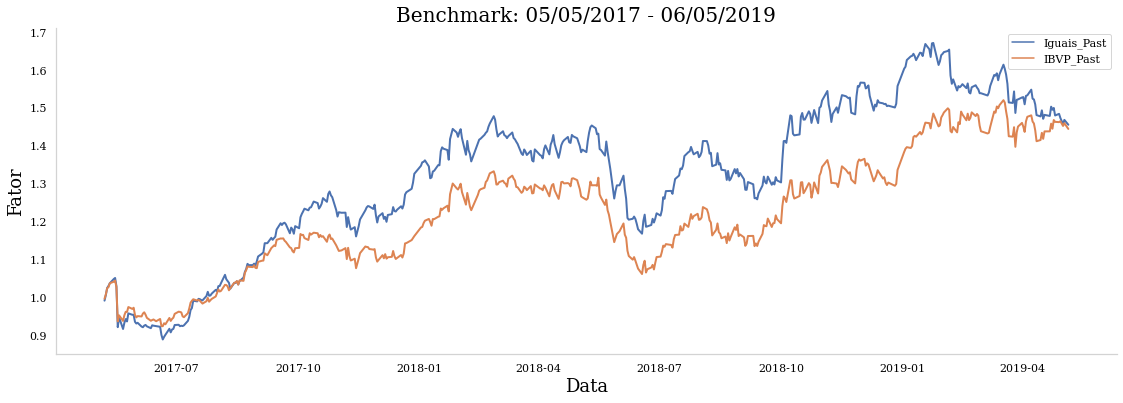

In [71]:
# baixando os dados
ibvp_past = qt.market_index('bvsp', start_past_dt, end_past_dt)

# armazenando em disco
# jl.dump(ibvp_past, 'past/ibvp_past.pkl')

# carregando-o e transformando em Portfolio
# ibvp_past = jl.load('past/ibvp_past.pkl')

ibvp_past_pf = Portfolio('IBVP_Past', ['IBVP'])
ibvp_past_pf.prices = ibvp_past
ibvp_past_pf.dates = (start_past_dt, end_past_dt)
Portfolio.register(ibvp_past_pf)

# plotly
# acoes_past.benchmark([ibvp_past_pf], plot_in='go')

# seaborn
acoes_past.benchmark([ibvp_past_pf], plot_in='sns', name='benchmark_past')

In [70]:
# taxa livre de risco - valor médio da Selic no período
selic_a_past = qt.selic(start_past_dt, end_past_dt, is_number=True)

# jl.dump(selic_a_past, 'past/selic_a_past.pkl')
# selic_a_past = jl.load('past/selic_a_past.pkl')

# conjunto de métricas do Portfolio
acoes_past.metrics(
    risk_free_rate=selic_a_past,
    window=21,
    benchmark=ibvp_past_pf
)

,Iguais_Past
Retorno_anual,0.197573
Volatilidade_anual,0.227885
Ind. Sharpe,0.710152
Ind. Sortino,0.906655
Beta,0.978229
Skewness,-0.955934
Ex_Curtose,3.456197
VaR_99.9,0.082491
CVaR_99.9,0.105106
Max_Drawdown_21,-0.172394


### Correlações

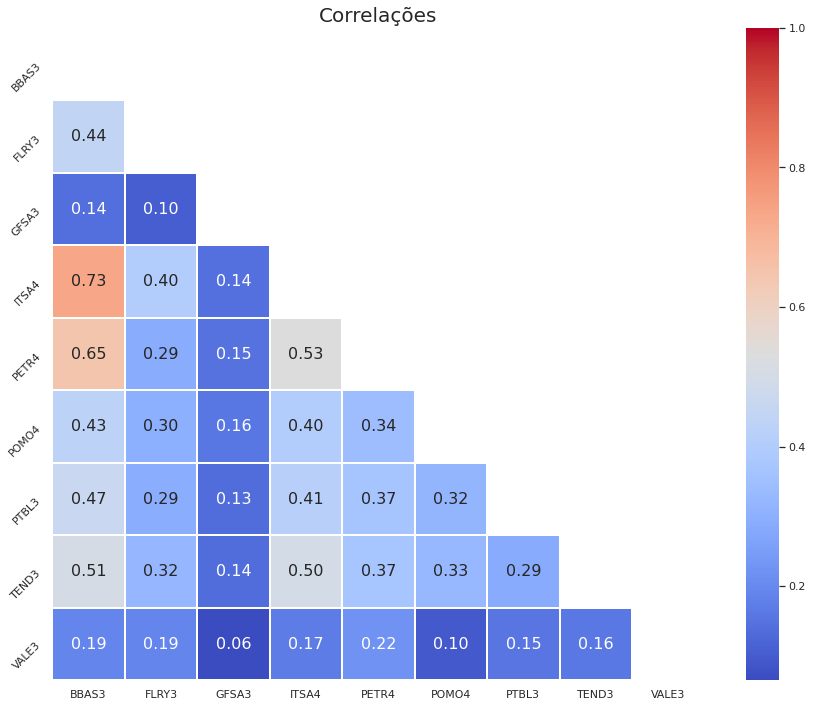

In [ ]:
qt.plot_heat_sns(acoes_past.d_returns(is_portfolio=False), size=(15, 12), rotate=True)

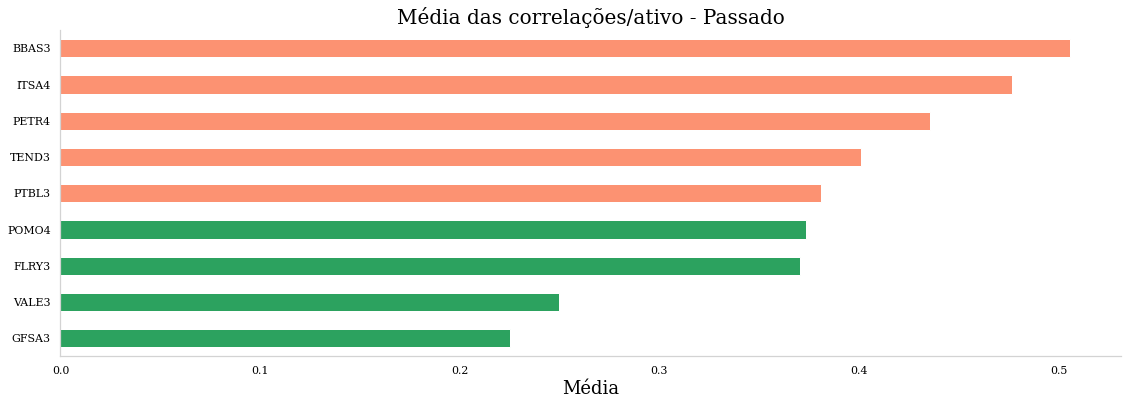

In [ ]:
correlations = acoes_past.d_returns(is_portfolio=False).corr()

medias = map(
    lambda col: (col, correlations[col].mean()),
    correlations
)

medias = pd.Series(data={media[0]: media[1] for media in medias}).sort_values()

cores = map(
    lambda m: '#2ca25f' if m < medias.mean() else '#fc9272',
    medias
)

medias.sort_values().plot(
    kind='barh',
    title='Média das correlações/ativo - Passado',
    color=list(cores),
    figsize=(19, 6)
)
plt.xlabel('Média');

del correlations, medias

Observamos que este conjunto de ativos apresenta alta correlação. As barras em tom de vermelho apresentam uma correlação acima da média das correlações.

## Carteira Futuro
Refazendo o procedimento para a carteira de período posterior.

In [16]:
start_fut_dt = dt(2019, 5, 6)
end_fut_dt = dt(2021, 5, 6)

acoes_fut = Portfolio('Iguais_Fut', acoes, start_fut_dt, end_fut_dt)
# jl.dump(acoes_fut, 'future/acoes_fut_pf.pkl')

# acoes_fut = jl.load('future/acoes_fut_pf.pkl')
# Portfolio.register(acoes_fut)

acoes_fut.prices.describe()

,BBAS3,FLRY3,GFSA3,ITSA4,PETR4,POMO4,PTBL3,TEND3,VALE3
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,37.897169,25.320542,5.112430,10.288072,24.341365,3.241968,5.374398,27.340542,59.710301
std,7.802895,3.142705,1.213081,1.254968,4.163692,0.678334,2.124957,4.525940,20.226250
min,21.570000,18.140000,2.530000,7.120000,11.290000,2.150000,1.750000,17.850000,32.730000
25%,30.732500,23.222500,4.410000,9.410000,21.982500,2.770000,4.070000,24.312500,45.322500
50%,34.860000,25.520000,4.915000,10.220000,24.895000,2.995000,4.550000,26.715000,51.230000
75%,45.587500,27.445000,5.600000,11.230000,27.500000,3.510000,6.552500,30.257500,62.805000
max,51.720000,32.810000,9.170000,13.100000,31.120000,5.480000,12.270000,39.580000,115.050000


### Retornos Individuais

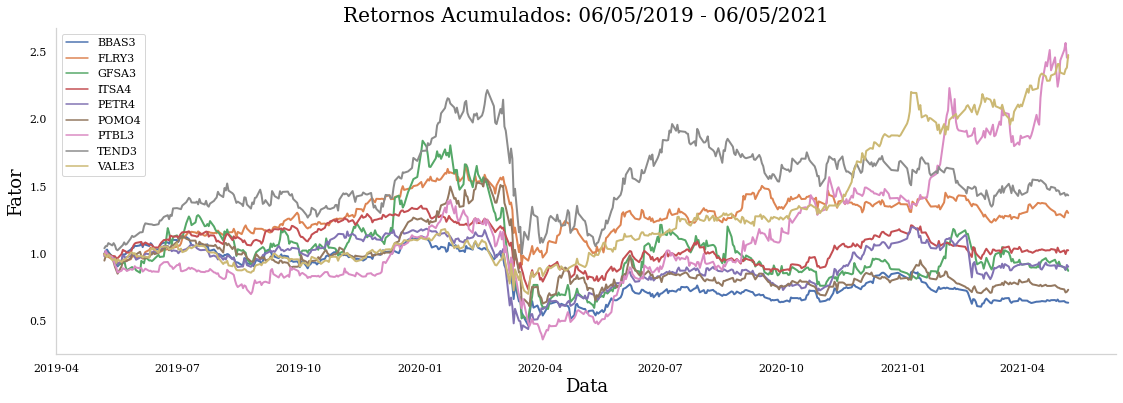

In [17]:
start_fut = start_fut_dt.strftime('%d/%m/%Y')
end_fut = end_fut_dt.strftime('%d/%m/%Y')

titles = [
    f'Retornos Acumulados: {start_fut} - {end_fut}',
    'Data',
    'Fator'
]

# qt.plot_lines_go([acoes_fut.acm_returns(is_portfolio=False)], titles)

qt.plot_lines_sns(acoes_fut.acm_returns(is_portfolio=False), titles, name='returns_fut')

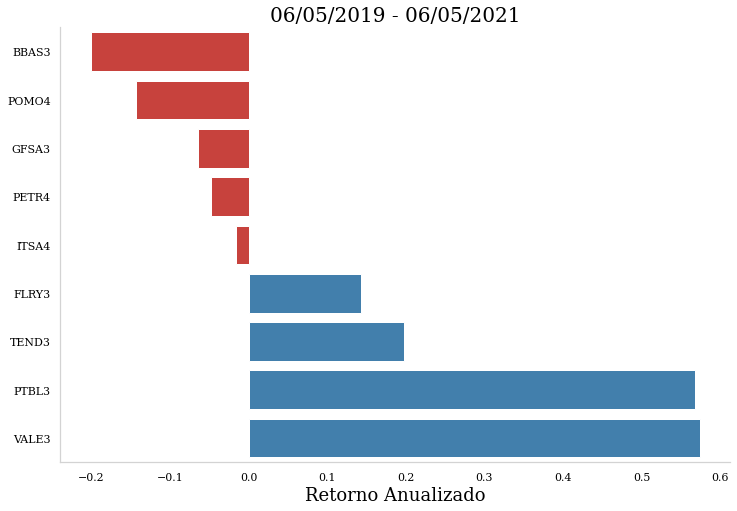

In [ ]:
# retornos
titles = [
    f'{start_fut} - {end_fut}',
    'Retorno Anualizado',
    None
]

qt.plot_returns_sns(acoes_fut.total_returns(), titles)

### Carteira: Retornos e Métricas
#### VaR e CVaR

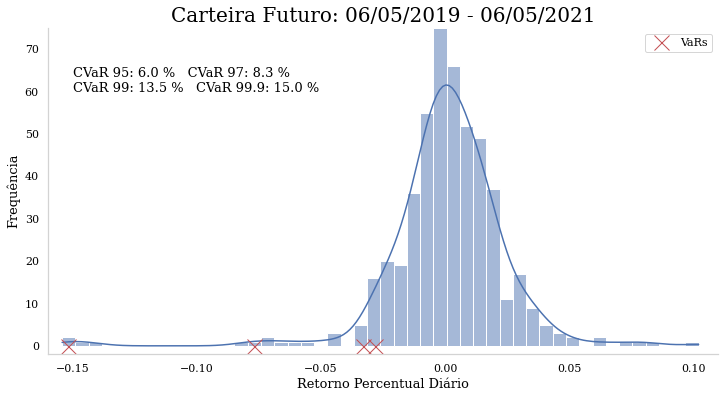

In [20]:
vars_fut = acoes_fut.var()
c_vars_fut = acoes_fut.cvar()

# plotly
# hist_data = [
#     acoes_fut.d_returns()['Retornos']
# ]

# group_labels = ['Retorno Percentual Diário']

# fig = ff.create_distplot(hist_data, group_labels, bin_size=.0025)

# fig.add_trace(
#     go.Scatter(
#         x=vars_fut.values,
#         y=np.zeros_like(vars_fut.values),
#         mode='markers',
#         marker_color='red',
#         marker_symbol='x',
#         name='VaR',
#         text=vars_fut.keys(),
#         hoverinfo='text+x'
#     )
# )


# fig.update_layout(
#     title=f'Carteira Passado: {start_fut} - {end_fut}',
#     yaxis=dict(
#         title='Frequência',
#         showgrid=False
#     ),
#     xaxis=dict(
#         showgrid=False,
#         showspikes=True,
#         spikethickness=2,
#         spikedash='dot',
#         spikecolor='#999999',
#         spikemode='across'
#     ),
#     plot_bgcolor="#FFF",
#     hoverdistance=100,
#     spikedistance=1000
# )

# fig.add_annotation(
#     x=-.12,
#     y=42,
#     text=f'CVaR 95: {round(c_vars_fut.loc[95], 2) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.08,
#     y=42,
#     text=f'CVaR 97: {round(c_vars_fut.loc[97], 3) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.12,
#     y=37,
#     text=f'CVaR 99: {round(c_vars_fut.loc[99], 3) * 100} %',
#     showarrow=False
# )

# fig.add_annotation(
#     x=-.08,
#     y=37,
#     text=f'CVaR 99.9: {round(c_vars_fut.loc[99.9], 2) * 100} %',
#     showarrow=False
# )

# fig.show()


# seaborn
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=acoes_fut.d_returns()['Retornos'],
    kde=True
)

plt.plot(
    vars_fut.values,
    [0, 0, 0, 0],
    'x',
    markersize=15,
    color='r',
    label='VaRs'
)

plt.axis([-.16, .11, -2, 75])
t = (
    f'CVaR 95: {round(c_vars_fut.loc[95], 2) * 100} %'
    f'   CVaR 97: {round(c_vars_fut.loc[97], 3) * 100} %'
    f'\nCVaR 99: {round(c_vars_fut.loc[99], 3) * 100} %'
    f'   CVaR 99.9: {round(c_vars_fut.loc[99.9], 2) * 100} %'
)

ax.text(-.15, 60, t, fontdict={'size': 13})

plt.legend()
plt.title(f'Carteira Futuro: {start_fut} - {end_fut}')
plt.xlabel('Retorno Percentual Diário', fontdict={'size': 13})
plt.ylabel('Frequência', fontdict={'size': 13})
plt.savefig('pictures/vars_fut.png', dpi=200)
plt.show()

#### Drawdown

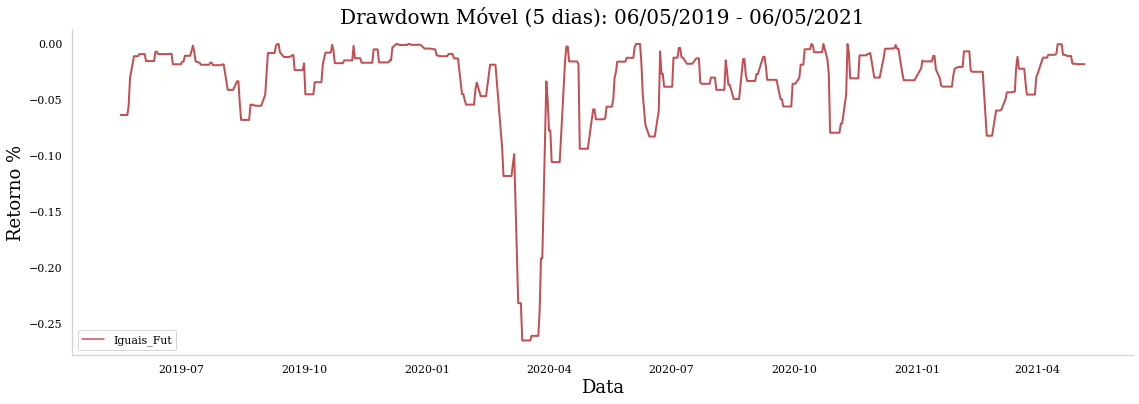

In [21]:
# plotly
# fig = go.Figure()

# window = 5
# fig.add_trace(
#     go.Scatter(
#         x=acoes_fut.rol_drawdown(window=window, is_number=False).index,
#         y=acoes_fut.rol_drawdown(window=window, is_number=False)['Iguais_Fut'],
#         marker={'color': 'rgba(152, 0, 0, .8)'}
#     )
# )

# fig.update_layout(
#     title=f'Drawdown Móvel ({window} dias): {start_fut} - {end_fut}',
#     yaxis=dict(
#         title='Retorno %',
#         showgrid=False
#     ),
#     xaxis=dict(
#         title='Data',
#         showgrid=False,
#         showspikes=True,
#         spikethickness=2,
#         spikedash='dot',
#         spikecolor='#999999',
#         spikemode='across'
#     ),
#     plot_bgcolor="#FFF",
#     hoverdistance=100,
#     spikedistance=1000
# )

# fig.show()


# seaborn
window = 5

titles = [
    f'Drawdown Móvel ({window} dias): {start_fut} - {end_fut}',
    'Data',
    'Retorno %'
]


qt.plot_lines_sns(
    acoes_fut.rol_drawdown(window=window, is_number=False),
    titles,
    color='r',
    name='draw_fut'
)

### Benchmark Futuro

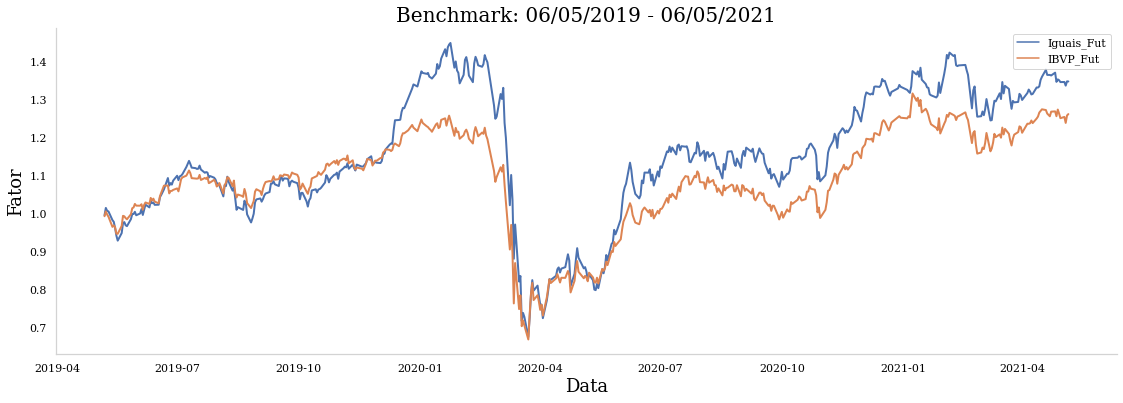

In [24]:
ibvp_fut = qt.market_index('bvsp', start_fut_dt, end_fut_dt)

# jl.dump(ibvp_fut, 'future/ibvp_fut.pkl')

# ibvp_fut = jl.load('future/ibvp_fut.pkl')

ibvp_fut_pf = Portfolio('IBVP_Fut', ['IBVP'])
ibvp_fut_pf.prices = ibvp_fut
ibvp_fut_pf.dates = (start_fut_dt, end_fut_dt)
Portfolio.register(ibvp_fut_pf)

# plotly
# acoes_fut.benchmark([ibvp_fut_pf], plot_in='go')

# seaborn
acoes_fut.benchmark([ibvp_fut_pf], plot_in='sns', name='benchmark_fut')

In [69]:
selic_a_fut = qt.selic(start_fut_dt, end_fut_dt, is_number=True)
# jl.dump(selic_a_fut, 'future/selic_a_fut.pkl')
# selic_a_fut = jl.load('future/selic_a_fut.pkl')

acoes_fut.metrics(
    risk_free_rate=selic_a_fut,
    window=21,
    benchmark=ibvp_fut_pf
)

,Iguais_Fut
Retorno_anual,0.117512
Volatilidade_anual,0.382918
Ind. Sharpe,0.259529
Ind. Sortino,0.280785
Beta,1.050651
Skewness,-1.735821
Ex_Curtose,9.146113
VaR_99.9,0.152205
CVaR_99.9,0.154443
Max_Drawdown_21,-0.519756


## Simulação - Geração Aleatória
Aqui 10.000 distribuições de pesos serão geradas aleatoriamente. A cada uma delas armazenaremos o retorno, a volatilidade e o índice de Sharpe da carteira gerada. Como um índice de Sharpe negativo não possui interpretação clara (a não ser a trivial, onde a carteira não superou a taxa livre de risco), substituiremos os índices negativos por zero.

In [27]:
%%time

# listas para armazenarmos as quantidades de interesse,
# como retorno, peso, variação e indíce de Sharpe
cart_returns = []
peso_acoes = []
cart_vols = []
sharpe = []

# estabelecendo o número de ativos e o número de carteiras a serem geradas,
# neste caso 10.000
n_acoes = len(acoes)
n_carts = 10_000

# retornos totais e covariância
a_returns_past = acoes_past.total_returns(scaled=False)
cov_past = acoes_past.covariance()

# loop de n_carts valores aleatórios para a geração de várias combinações;
for _ in range(n_carts):
    peso = np.random.random(n_acoes)
    peso /= np.sum(peso)                                # normalizando-os

    ret = (1 + a_returns_past.dot(peso)) ** .5 - 1      # retorno da carteira anualizado

    vol = qt.vol(peso, cov_past, annual=True)          # volatilidade

    s = qt.sharpe(ret, vol, selic_a_past)              # índice de Sharpe

    cart_returns.append(ret)
    peso_acoes.append(peso)
    cart_vols.append(vol)
    sharpe.append(s)


# transformando as listas em arrays
cart_returns = np.array(cart_returns)
peso_acoes = np.array(peso_acoes)
cart_vols = np.array(cart_vols)

# substituindo os índices negativos por 0
sharpe = np.where(np.array(sharpe) > 0, sharpe, 0)

CPU times: user 488 ms, sys: 0 ns, total: 488 ms
Wall time: 486 ms


Entre todas as carteiras geradas, selecionaremos a da menor volatilidade e de maior índice de Sharpe.

In [28]:
carteira = {
    'Retorno': cart_returns,
    'Volatilidade': cart_vols,
    'Ind. Sharpe': sharpe
}


# loop que adiciona cada ação pertencente a 'ações', com seus respectivos pesos
# (obtidos na célula anterior) à 'carteira'
for k, acao in enumerate(acoes):
    carteira[acao] = [p[k] for p in peso_acoes]


cart_aux = pd.DataFrame(carteira)
cols = ['Retorno', 'Volatilidade', 'Ind. Sharpe'] + [acao for acao in acoes]
cart_aux = cart_aux[cols]


# carteiras de mínima volatilidade e maior índice de Sharpe
carteira_min_vol = qt.find_port_min_vol(cart_aux)
carteira_max_sr = qt.find_port_max_sr(cart_aux)

#### Fronteira Eficiente
Para cada carteira gerada acima, podemos atribuí-la a um ponto no plano retorno vs risco. Em especial, note que as carteiras otimizadas estão concentradas nos extremos (não no interior). Isso reflete-se quando construímos a fronteira eficiente (por minimização da volatilidade, não apresentada aqui).

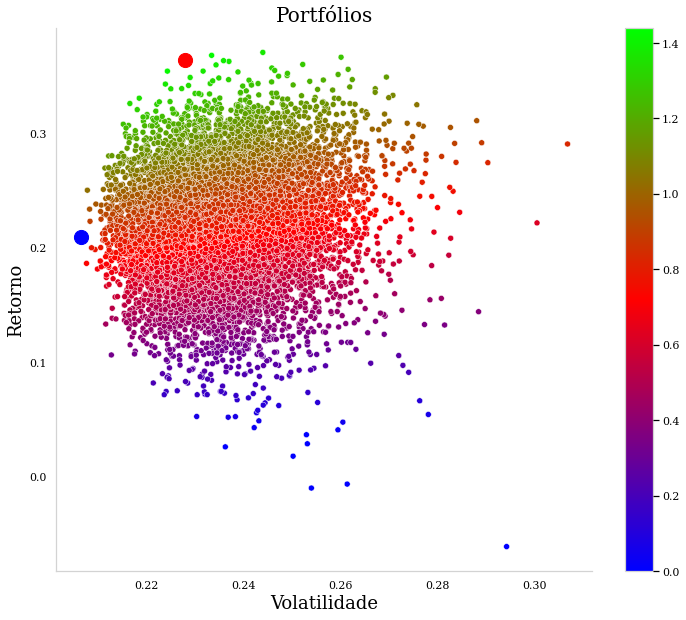

In [29]:
qt.plot_portfolios(cart_aux)

Agora transformaremos as carteiras selecionadas da simulação em objetos da classe Portfolio. O método self.transfer(new_name, new_weights) copia o Portfolio self e lhe fornece um novo nome e novos pesos. Como esperado, aos novos Portfolios fornecemos os pesos obtidos acima.

In [ ]:
acoes_sim_min_vol = acoes_fut.transfer(
    'Sim. Min. Vol.',
    carteira_min_vol.loc[acoes, 'Valores'].values
)

acoes_sim_max_sr = acoes_fut.transfer(
    'Sim. Max. Sharpe',
    carteira_max_sr.loc[acoes, 'Valores'].values
)

# armazenando em disco
# jl.dump(acoes_sim_min_vol, 'future/acoes_sim_min_vol_pf.pkl')
# jl.dump(acoes_sim_max_sr, 'future/acoes_sim_max_sr_pf.pkl')

# acoes_sim_min_vol = jl.load('future/acoes_sim_min_vol_pf.pkl')
# Portfolio.register(acoes_sim_min_vol)

# acoes_sim_max_sr = jl.load('future/acoes_sim_max_sr_pf.pkl')
# Portfolio.register(acoes_sim_max_sr)

## Otimizações

Realizaremos então as otimizações convexas para comparar com as carteiras até agora obtidas.

### Estimando Retornos
- Média Histórica

In [38]:
a_returns_fut = acoes_fut.total_returns(scaled=False)

ret_past_mean = pf.expected_returns.mean_historical_return(
    prices=acoes_past.prices,
    compounding=True
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_mean)

MAE: 0.5375666305536593
RMSE: 0.6373810674902887


- Média Exponencial

In [39]:
ret_past_ema = pf.expected_returns.ema_historical_return(
    prices=acoes_past.prices,
    compounding=True
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_ema)

MAE: 0.6125973359307797
RMSE: 0.72235995747894


- Modelo CAPM: a ser escolhido. Apesar do retorno médio histórico ter sido mais um pouco mais assertivo no período, o modelo CAPM costuma ser a melhor escolha. Como as métricas de erro não foram significativamente maiores, prosseguiremos de fato com este modelo.

In [40]:
selic_d_past = (1 + selic_a_past) ** (1/252) - 1

ret_past_capm = pf.expected_returns.capm_return(
    prices=acoes_past.prices,
    market_prices=ibvp_past,
    risk_free_rate=selic_d_past
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_capm)

MAE: 0.5557875673290832
RMSE: 0.6994230196459675


### Modelos de Risco

In [41]:
# sample covariance
samplecov_past = pf.risk_models.sample_cov(acoes_past.prices)
samplecov_fut = pf.risk_models.sample_cov(acoes_fut.prices)

print(f'M.A.E. para sample covariance: {qt.mae_cov(samplecov_past, samplecov_fut)} %')

# semicovariance
selic_d_fut = (1 + selic_a_fut) ** (1/252) - 1

semicov_past = pf.risk_models.semicovariance(
    prices=acoes_past.prices,
    benchmark=selic_d_past
)
semicov_fut = pf.risk_models.semicovariance(
    prices=acoes_fut.prices,
    benchmark=selic_d_fut
)

print(f'M.A.E. para semi covariance: {qt.mae_cov(semicov_past, semicov_fut)} %')

# exponential
expcov_past = pf.risk_models.exp_cov(prices=acoes_past.prices)
expcov_fut = pf.risk_models.exp_cov(prices=acoes_fut.prices)

print(f'M.A.E. para exponential covariance: {qt.mae_cov(expcov_past, expcov_fut)} %')

# ledoit wolf
lwcov_past = pf.risk_models.CovarianceShrinkage(acoes_past.prices).ledoit_wolf()
lwcov_fut = pf.risk_models.CovarianceShrinkage(acoes_fut.prices).ledoit_wolf()

print(f'M.A.E. para Ledoit Wolf covariance: {qt.mae_cov(lwcov_past, lwcov_fut)} %')

M.A.E. para sample covariance: 13.99 %
M.A.E. para semi covariance: 6.72 %
M.A.E. para exponential covariance: 8.559999999999999 %
M.A.E. para Ledoit Wolf covariance: 13.969999999999999 %


Por motivos análogos ao modelo CAPM, para o caso dos modelos de risco seguiremos com o Ledoit Wolf.

#### Mínima Volatilidade

In [42]:
model = pf.EfficientFrontier(
    expected_returns=ret_past_capm,
    cov_matrix=lwcov_past
)

# no mínimo 3% por ativo
for t in acoes:
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= .03)

model.min_volatility()

OrderedDict([('BBAS3', 0.03),
             ('FLRY3', 0.1830417541323547),
             ('GFSA3', 0.0998784207478601),
             ('ITSA4', 0.1269416844149936),
             ('PETR4', 0.03),
             ('POMO4', 0.0969226949126658),
             ('PTBL3', 0.0839949975183727),
             ('TEND3', 0.1590827552295629),
             ('VALE3', 0.1901376930441901)])

In [43]:
pesos_min_vol = np.array(
    list(model.clean_weights().values())
)

# com os pesos adquiridos, criamos um novo
# Portfolio a partir do método .transfer()
acoes_opt_min_vol = acoes_fut.transfer(
    'Opt. Min. Vol.',
    pesos_min_vol
)

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 17.7%
Annual volatility: 20.5%
Sharpe Ratio: 0.69


(0.17733303760049357, 0.20467055035516193, 0.6918072067302771)

In [45]:
print(
      f'Beta da carteira {acoes_opt_min_vol.name}: '
      f'{round(acoes_opt_min_vol.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=acoes_opt_min_vol.volatility(),
      vol_eq=acoes_fut.volatility(),
      ret_opt=acoes_opt_min_vol.portfolio_return(),
      ret_eq=acoes_fut.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Opt. Min. Vol.: 0.973591

Volatlidade com os pesos otimizados: 35.839999999999996 %
Volatilidade com os pesos iguais: 38.29 %
Diferença percentual: + 6.3985 %

Retorno com os pesos otimizados: 19.13 %
Retorno com os pesos iguais: 11.75 %
Diferença percentual: + 62.8085 %

Índice de Sharpe com os pesos otimizados: 0.4832
Índice de Sharpe com os pesos iguais: 0.2595 
Diferença percentual: + 86.2042 %



#### Máximo Índice de Sharpe

In [46]:
model = pf.EfficientFrontier(
    expected_returns=ret_past_capm,
    cov_matrix=lwcov_past
)

# no mínimo 3% por ativo
for t in acoes:
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= .03)

model.max_sharpe(risk_free_rate=selic_a_past)

OrderedDict([('BBAS3', 0.2267717778172038),
             ('FLRY3', 0.03),
             ('GFSA3', 0.03),
             ('ITSA4', 0.2970398033653952),
             ('PETR4', 0.1916462057574755),
             ('POMO4', 0.03),
             ('PTBL3', 0.03),
             ('TEND3', 0.03),
             ('VALE3', 0.1345422130599254)])

In [47]:
pesos_max_sr = np.array(
    list(model.clean_weights().values())
)

acoes_opt_max_sr = acoes_fut.transfer(
    'Opt. Max. Sharpe',
    pesos_max_sr
)
del pesos_max_sr

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 25.5%
Annual volatility: 26.3%
Sharpe Ratio: 0.83


(0.2552924406761849, 0.2631260847953657, 0.8343983265193602)

In [49]:
print(
      f'Beta da carteira {acoes_opt_max_sr.name}: '
      f'{round(acoes_opt_max_sr.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=acoes_opt_max_sr.volatility(),
      vol_eq=acoes_fut.volatility(),
      ret_opt=acoes_opt_max_sr.portfolio_return(),
      ret_eq=acoes_fut.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Opt. Max. Sharpe: 1.085319

Volatlidade com os pesos otimizados: 38.440000000000005 %
Volatilidade com os pesos iguais: 38.29 %
Diferença percentual: - 0.3917 %

Retorno com os pesos otimizados: 4.859999999999999 %
Retorno com os pesos iguais: 11.75 %
Diferença percentual: - 58.6383 %

Índice de Sharpe com os pesos otimizados: 0.0793
Índice de Sharpe com os pesos iguais: 0.2595 
Diferença percentual: - 69.4412 %



#### Retorno e Risco Eficiente

In [50]:
model = pf.EfficientFrontier(
    ret_past_capm,
    lwcov_past
)

# no mínimo 3% por ativo
for t in acoes:
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= .03)

# maximizando o retorno para um risco de 25%
model.efficient_risk(target_volatility=.25)

OrderedDict([('BBAS3', 0.1739258343715461),
             ('FLRY3', 0.0620915772432441),
             ('GFSA3', 0.0300000158029806),
             ('ITSA4', 0.3188148026394682),
             ('PETR4', 0.1659503420843476),
             ('POMO4', 0.033103448655253),
             ('PTBL3', 0.0300001194515403),
             ('TEND3', 0.030000796763854),
             ('VALE3', 0.1561130629875294)])

In [51]:
pesos_max_ret_risk = np.array(
    list(model.clean_weights().values())
)

acoes_max_ret_risk = acoes_fut.transfer(
    'Max. Ret. Risk 25%',
    pesos_max_ret_risk
)
del pesos_max_ret_risk

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 24.4%
Annual volatility: 25.0%
Sharpe Ratio: 0.83


(0.2435453490659255, 0.24999999925828525, 0.8312194952924511)

In [52]:
print(
      f'Beta da carteira {acoes_max_ret_risk.name}: '
      f'{round(acoes_max_ret_risk.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=acoes_max_ret_risk.volatility(),
      vol_eq=acoes_fut.volatility(),
      ret_opt=acoes_max_ret_risk.portfolio_return(),
      ret_eq=acoes_fut.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Max. Ret. Risk 25%: 1.050712

Volatlidade com os pesos otimizados: 37.059999999999995 %
Volatilidade com os pesos iguais: 38.29 %
Diferença percentual: + 3.2123 %

Retorno com os pesos otimizados: 7.7700000000000005 %
Retorno com os pesos iguais: 11.75 %
Diferença percentual: - 33.8723 %

Índice de Sharpe com os pesos otimizados: 0.1607
Índice de Sharpe com os pesos iguais: 0.2595 
Diferença percentual: - 38.0732 %



In [53]:
model = pf.EfficientFrontier(
    ret_past_capm,
    lwcov_past
)

# no mínimo 3% por ativo
for t in acoes:
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= .03)

# minimizando o risco para um retorno de 20%
model.efficient_return(target_return=.2)

OrderedDict([('BBAS3', 0.03),
             ('FLRY3', 0.1328140105573279),
             ('GFSA3', 0.0554585238950534),
             ('ITSA4', 0.2742952541024694),
             ('PETR4', 0.0781489958729296),
             ('POMO4', 0.0757712010727899),
             ('PTBL3', 0.0694819102751632),
             ('TEND3', 0.1087640072037034),
             ('VALE3', 0.1752660970205632)])

In [54]:
pesos_min_risk_ret = np.array(
    list(model.clean_weights().values())
)

acoes_min_risk_ret = acoes_fut.transfer(
    'Min. Risk Ret. 20%',
    pesos_min_risk_ret
)
del pesos_min_risk_ret

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 20.0%
Annual volatility: 21.3%
Sharpe Ratio: 0.77


(0.19999999999999998, 0.21292550428960302, 0.7714412826621642)

In [55]:
print(
      f'Beta da carteira {acoes_min_risk_ret.name}: '
      f'{round(acoes_min_risk_ret.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=acoes_min_risk_ret.volatility(),
      vol_eq=acoes_fut.volatility(),
      ret_opt=acoes_min_risk_ret.portfolio_return(),
      ret_eq=acoes_fut.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Min. Risk Ret. 20%: 0.978237

Volatlidade com os pesos otimizados: 34.74 %
Volatilidade com os pesos iguais: 38.29 %
Diferença percentual: + 9.2714 %

Retorno com os pesos otimizados: 16.259999999999998 %
Retorno com os pesos iguais: 11.75 %
Diferença percentual: + 38.383 %

Índice de Sharpe com os pesos otimizados: 0.4159
Índice de Sharpe com os pesos iguais: 0.2595 
Diferença percentual: + 60.2697 %



### Hierarchical Risk Parity

In [56]:
# objeto
hrp = pf.HRPOpt(returns=acoes_past.d_returns(is_portfolio=False))

# otimização
hrp.optimize()

OrderedDict([('BBAS3', 0.04251804610377106),
             ('FLRY3', 0.18983576587737191),
             ('GFSA3', 0.09024907287913868),
             ('ITSA4', 0.08100389332584691),
             ('PETR4', 0.05742632490414509),
             ('POMO4', 0.13860391914323264),
             ('PTBL3', 0.09878424909025023),
             ('TEND3', 0.1396450928155882),
             ('VALE3', 0.16193363586065526)])

In [57]:
pesos_hrp = np.array(
    list(hrp.clean_weights().values())
)

acoes_hrp = acoes_fut.transfer(
    'HRP',
    pesos_hrp
)
del pesos_hrp

hrp.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 20.6%
Annual volatility: 21.2%
Sharpe Ratio: 0.80


(0.20609143449908474, 0.21232615769158894, 0.8023079232997042)

In [58]:
print(
      f'Beta da carteira {acoes_hrp.name}: '
      f'{round(acoes_hrp.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=acoes_hrp.volatility(),
      vol_eq=acoes_fut.volatility(),
      ret_opt=acoes_hrp.portfolio_return(),
      ret_eq=acoes_fut.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira HRP: 0.992033

Volatlidade com os pesos otimizados: 36.7 %
Volatilidade com os pesos iguais: 38.29 %
Diferença percentual: + 4.1525 %

Retorno com os pesos otimizados: 17.06 %
Retorno com os pesos iguais: 11.75 %
Diferença percentual: + 45.1915 %

Índice de Sharpe com os pesos otimizados: 0.4154
Índice de Sharpe com os pesos iguais: 0.2595 
Diferença percentual: + 60.0771 %



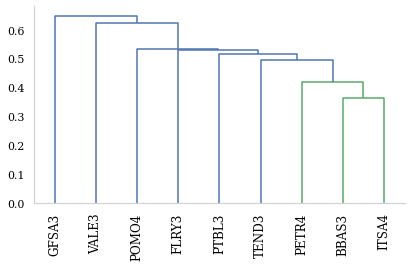

In [ ]:
from pypfopt import plotting

plotting.plot_dendrogram(
    hrp=hrp,
    ax=None,
    show_tickers=True
);

In [67]:
# armazenando os Portfolios em disco
ps = (
    (acoes_opt_min_vol, 'acoes_opt_min_vol'), (acoes_opt_max_sr, 'acoes_opt_max_sr'),
    (acoes_max_ret_risk, 'acoes_max_ret_risk'), (acoes_min_risk_ret, 'acoes_min_risk_ret'),
    (acoes_hrp, 'acoes_hrp')
)

for p in ps:
    jl.dump(p[0], f'future/{p[1]}_pf.pkl')

In [ ]:
# ao carregá-los diretamente, a etapa de otimização acima pode ser
# pulada

# acoes_opt_min_vol = jl.load('future/acoes_opt_min_vol_pf.pkl')
# Portfolio.register(acoes_opt_min_vol)

# acoes_opt_max_sr = jl.load('future/acoes_opt_max_sr_pf.pkl')
# Portfolio.register(acoes_opt_max_sr)

# acoes_max_ret_risk = jl.load('future/acoes_max_ret_risk_pf.pkl')
# Portfolio.register(acoes_max_ret_risk)

# acoes_min_risk_ret = jl.load('future/acoes_min_risk_ret_pf.pkl')
# Portfolio.register(acoes_min_risk_ret)

# acoes_hrp = jl.load('future/acoes_hrp_pf.pkl')
# Portfolio.register(acoes_hrp)

## Comparação Entre as Otimizações

In [60]:
rets = Portfolio.all_rets()[4:]
vols = Portfolio.all_vols()[4:]
sharpes = Portfolio.all_sindex(selic_a_fut)[4:]

ret_cores = map(
    lambda r: 'red' if r < acoes_fut.portfolio_return() else 'blue',
    rets
)

vol_cores = map(
    lambda v: 'blue' if v < acoes_fut.volatility() else 'red',
    vols
)

sharpe_cores = map(
    lambda s: 'red' if s < acoes_fut.s_index(selic_a_fut) else 'blue',
    sharpes
)

colors = {
    'rets': list(ret_cores),
    'vols': list(vol_cores),
    'sharpes': list(sharpe_cores)
}

# como a imagem do plotly não é renderizada no github,
# insiro o png da mesma
qt.plot_opt_comparisons(rets, vols, sharpes, colors)

![comparison](./pictures/comparison.png)

Das carteiras otimizadas, portanto, prosseguiremos somente com as que apresentaram boa performance: Sim. Min. Vol., Sim. Max. Sharpe, Opt. Min. Vol., Min. Risk Ret. 20% e HRP. Com elas, utilizamos o método .all_metrics(), que recebe uma lista de Portfolios, para avaliar as métricas de cada um e, por fim, um benchmark entre todos.

In [61]:
port_comparison = [
    ibvp_fut_pf, acoes_fut, acoes_sim_min_vol,
    acoes_sim_max_sr, acoes_opt_min_vol,
    acoes_min_risk_ret, acoes_hrp
]

Portfolio.all_metrics(
    portfolios=port_comparison,
    risk_free_rate=selic_a_fut,
    window=21,
    benchmark=ibvp_fut_pf
)

,IBVP_Fut,Iguais_Fut,Sim. Min. Vol.,Sim. Max. Sharpe,Opt. Min. Vol.,Min. Risk Ret. 20%,HRP
Retorno_anual,0.125057,0.117512,0.167471,0.315004,0.191326,0.162618,0.17059
Volatilidade_anual,0.341899,0.382918,0.354784,0.380356,0.358354,0.347394,0.366985
Ind. Sharpe,0.312734,0.259529,0.420925,0.780506,0.483299,0.415909,0.415431
Ind. Sortino,0.347802,0.280785,0.462733,0.867324,0.524886,0.461352,0.44844
Beta,1.0,1.050651,0.954416,1.025261,0.973591,0.978237,0.992033
Skewness,-1.150424,-1.735821,-1.756646,-1.334363,-1.758124,-1.491358,-1.85277
Ex_Curtose,11.835103,9.146113,8.979388,9.921085,9.33175,8.568075,9.908926
VaR_99.9,0.14354,0.152205,0.146033,0.151457,0.146826,0.1399,0.150634
CVaR_99.9,0.147797,0.154443,0.14918,0.151701,0.149637,0.140104,0.153521
Max_Drawdown_21,-0.44522,-0.519756,-0.478447,-0.470532,-0.480263,-0.468171,-0.495364


### Benchmark
Notamos que as carteiras caminham aproximadas por um período, mas começam a separar-se de fato um pouco antes de julho, na retomada da pandemia. Dado que a carteira Sim. Max. Sharpe, de melhor performance, atribui um peso maior a TEND3, VALE3 e PTBL3 (ver abaixo), ligadas ao setor de construção, mineração/commodities e industrial, respectivamente, indicando uma recuperação mais forte dos setores no período (também há do ciclo de alta das commodities). Ressalva-se mais uma vez a importância de aliar esta análise com uma fundamentalista.

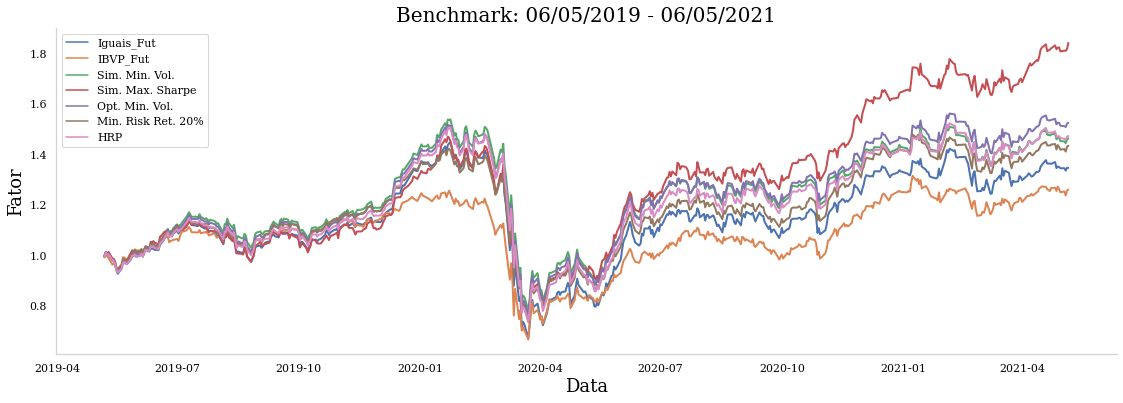

In [66]:
# port_comparison.pop(1)

# plotly
# acoes_fut.benchmark(
#     port_comparison,
#     plot_in='go'
# )

# seaborn
acoes_fut.benchmark(
    port_comparison,
    plot_in='sns',
    name='all_benchmark'
)

### Conclusões

Observamos que a carteira de melhor performance, em questão de retorno por risco (índice de Sharpe), é a **Sim. Max. Sharpe**---gerada aleatoriamente---com retorno anual de 31.50% e volatilidade de 38.04%. A volatilidade, no entanto, pode ser um pouco alta para alguns investidores e, para este caso, sobre a que apresentou menor variação da distribuição dos preços, cito a **Min. Risk Ret. 20%**, com 34.78%. Como, porém, o retorno desta é consideravelmente abaixo da **Sim. Max. Sharpe**, acredito que seja mais interessante enfrentar uma volatilidade brevemente superior para um retorno substancialmente mais favorável. De mais relevante, também, observamos que as carteiras obtidas pela geração aleatória mostram-se como boas candidatas para um cenário de otimização. Por fim, seguem abaixo os pesos das duas otimizações comentadas.

In [64]:
pesos = pd.DataFrame(
    {'Sim. Max. Sharpe': acoes_sim_max_sp.weights,
    'Min. Risk Ret. 20%': acoes_min_risk_ret.weights}
)
pesos.index = acoes
pesos

,Sim. Max. Sharpe,Min. Risk Ret. 20%
BBAS3,0.012573,0.03000
FLRY3,0.035335,0.13281
GFSA3,0.020244,0.05546
ITSA4,0.017194,0.27430
PETR4,0.072857,0.07815
POMO4,0.106538,0.07577
PTBL3,0.116523,0.06948
TEND3,0.249402,0.10876
VALE3,0.369334,0.17527


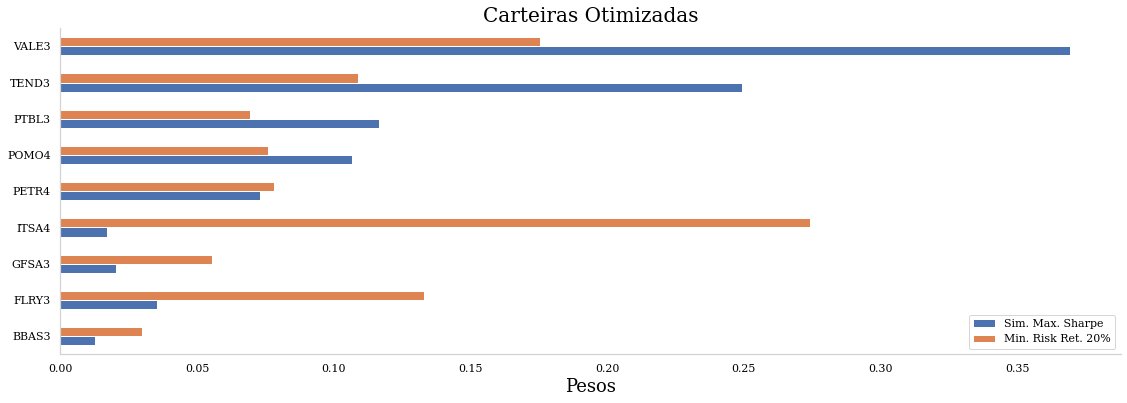

In [72]:
pesos.plot(
    kind='barh', figsize=(19, 6),
    title='Carteiras Otimizadas'
)
plt.xlabel('Pesos');
plt.savefig('pictures/cart_opt.png', dpi=200)
plt.show()